In [1]:
import sys
import os

# 添加 model_main.py 所在目录到 sys.path
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # 加入 E:/模型/star/

# 现在可以导入了
from model_main import TransformerMoE


In [2]:
model = TransformerMoE()
print(model)


TransformerMoE(
  (layers): ModuleList(
    (0-3): 4 x TransformerMoEBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
      )
      (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (moe): NoisyTopKMoE(
        (experts): MLPExperts(
          (fc1): Linear(in_features=1152, out_features=61440, bias=True)
          (fc2): Linear(in_features=2048, out_features=1152, bias=True)
        )
        (gate): Linear(in_features=1152, out_features=30, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=1152, out_features=2, bias=True)
  )
)


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 设置保存路径
fig_save_dir = "/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/"
data_save_dir = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/"
os.makedirs(fig_save_dir, exist_ok=True)
os.makedirs(data_save_dir, exist_ok=True)

In [4]:
# 文件路径
attn_weights_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/attn_weights.npy"
gate_scores_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/gate_scores.npy"
labels_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/labels.npy"
topk_idx_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/topk_idx.npy"

# 加载
attn_weights = np.load(attn_weights_path)
gate_scores = np.load(gate_scores_path)
labels = np.load(labels_path)
topk_idx = np.load(topk_idx_path)

# 打印shape和部分内容
print("attn_weights.shape:", attn_weights.shape)
print("attn_weights sample:", attn_weights.ravel()[:10])
print("gate_scores.shape:", gate_scores.shape)
print("gate_scores sample:", gate_scores.ravel()[:10])
print("labels.shape:", labels.shape)
print("labels sample:", labels[:10])
print("topk_idx.shape:", topk_idx.shape)
print("topk_idx sample:", topk_idx.ravel()[:10])

attn_weights.shape: (4, 1149, 300, 300)
attn_weights sample: [0.00315135 0.00324851 0.00317532 0.00323901 0.0032711  0.00321354
 0.00327827 0.00323689 0.00320113 0.00310806]
gate_scores.shape: (4, 1149, 300, 30)
gate_scores sample: [0.0207345  0.02039494 0.02406792 0.00924489 0.11641277 0.029995
 0.01294383 0.00632213 0.03426803 0.01324991]
labels.shape: (1149,)
labels sample: [1 1 1 1 1 1 1 1 1 1]
topk_idx.shape: (4, 1149, 300, 3)
topk_idx sample: [ 4 19 21 14  4 19  4 14 19  4]


## 统计各个专家的使用频率

专家使用频率: [155427 143621  76569 140242 278742 105259  92625 117328  79853 134443
  80998 142911 138172 135457 125993 125233 109300 100920 192644 113523
 131351 123406 174520 158406 127914 106291 193389 129606 115289 286968]


,expert_id,count
0,0,155427
1,1,143621
2,2,76569
3,3,140242
4,4,278742
5,5,105259
6,6,92625
7,7,117328
8,8,79853
9,9,134443


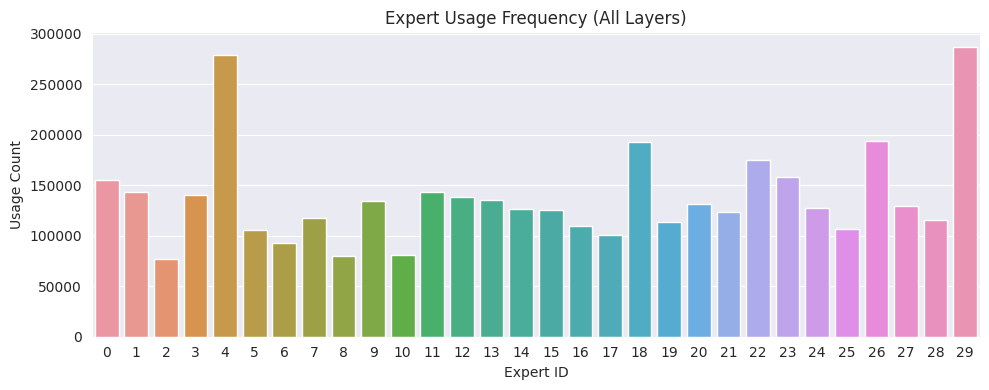

In [5]:
all_expert_ids = topk_idx.reshape(-1)
num_experts = gate_scores.shape[-1]
expert_ids, counts = np.unique(all_expert_ids, return_counts=True)
expert_freq = np.zeros(num_experts, dtype=int)
for eid, cnt in zip(expert_ids, counts):
    expert_freq[eid] = cnt
print("专家使用频率:", expert_freq)

df_expert_freq = pd.DataFrame({"expert_id": np.arange(num_experts), "count": expert_freq})
df_expert_freq.to_csv(os.path.join(data_save_dir, "expert_usage_freq.csv"), index=False)
display(df_expert_freq)

plt.figure(figsize=(10,4))
sns.barplot(x=np.arange(num_experts), y=expert_freq)
plt.xlabel("Expert ID")
plt.ylabel("Usage Count")
plt.title("Expert Usage Frequency (All Layers)")
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, "expert_usage_freq.pdf"),format='pdf', bbox_inches='tight')
plt.show()
plt.close()

## 统计门控分数分布

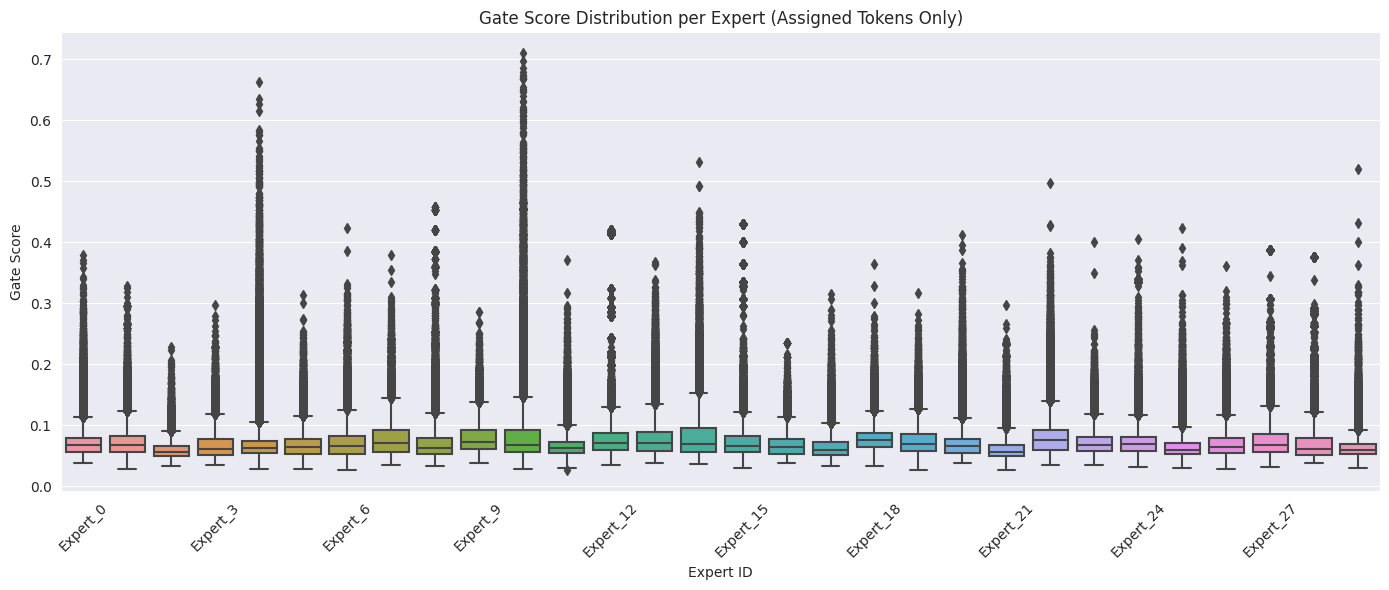

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 gate_scores: (num_layers, num_seqs, seq_len, num_experts)
# topk_idx: (num_layers, num_seqs, seq_len, topk)
num_layers, num_seqs, seq_len, num_experts = gate_scores.shape
topk = topk_idx.shape[-1]

# 收集每个专家被分配到的所有非零分数
expert_gate_scores = [[] for _ in range(num_experts)]
for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            for k in range(topk):
                eid = topk_idx[layer, i, t, k]
                score = gate_scores[layer, i, t, eid]
                expert_gate_scores[eid].append(score)

# 转为DataFrame，方便画图
df_expert_gate_scores = pd.DataFrame(dict([(f"Expert_{i}", pd.Series(scores)) for i, scores in enumerate(expert_gate_scores)]))

# 画箱型图
plt.figure(figsize=(14,6))
ax = sns.boxplot(data=df_expert_gate_scores, showfliers=True)
plt.xlabel("Expert ID")
plt.ylabel("Gate Score")
plt.title("Gate Score Distribution per Expert (Assigned Tokens Only)")
step = max(1, num_experts // 10)
ax.set_xticks(np.arange(0, num_experts, step))
ax.set_xticklabels([f"Expert_{i}" for i in range(0, num_experts, step)], rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, "gate_score_distribution_assigned_only.pdf"), format='pdf', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2795588/1940686820.py:32: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from curren

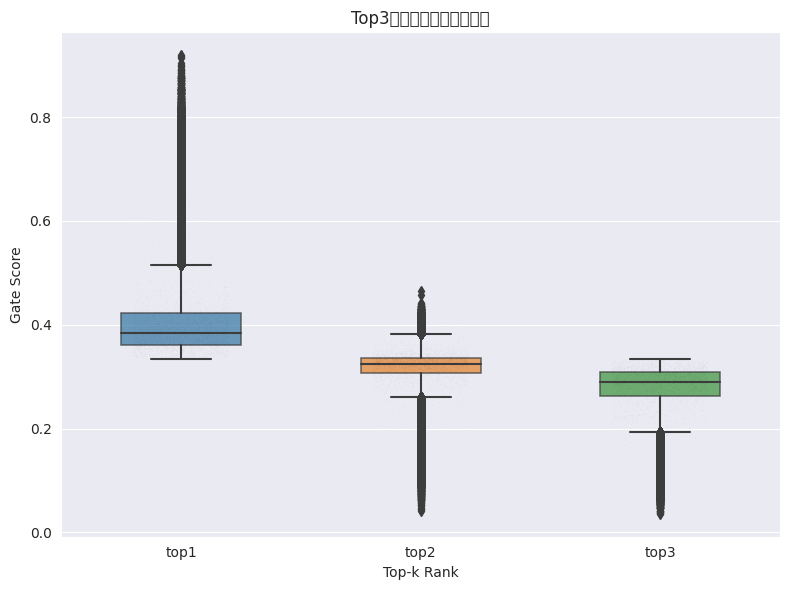

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
topk_vals = []
for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            vals = []
            for k in range(topk_idx.shape[-1]):
                eid = topk_idx[layer, i, t, k]
                vals.append(gate_scores[layer, i, t, eid])
            vals = np.array(vals)
            vals_norm = vals / (vals.sum() + 1e-9)
            topk_vals.append(vals_norm)
topk_vals = np.vstack(topk_vals)  # shape: [N, 3]
# 假设 topk_vals 是 shape [N, 3] 的 numpy 数组
df_topk = pd.DataFrame(topk_vals, columns=['top1', 'top2', 'top3'])

plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df_topk, width=0.5, showfliers=True, boxprops=dict(alpha=0.7, linewidth=1.2))
# 采样每列3000个点
sample_n = 3000
df_sampled = pd.concat([
    df_topk[col].sample(n=sample_n, random_state=42).reset_index(drop=True)
    for col in df_topk.columns
], axis=1)
sns.stripplot(data=df_sampled, size=0.5, color="k", alpha=0.05, jitter=0.2, ax=ax)

plt.title("Top3归一化后门控分数分布")
plt.ylabel("Gate Score")
plt.xlabel("Top-k Rank")
plt.tight_layout()
plt.show()

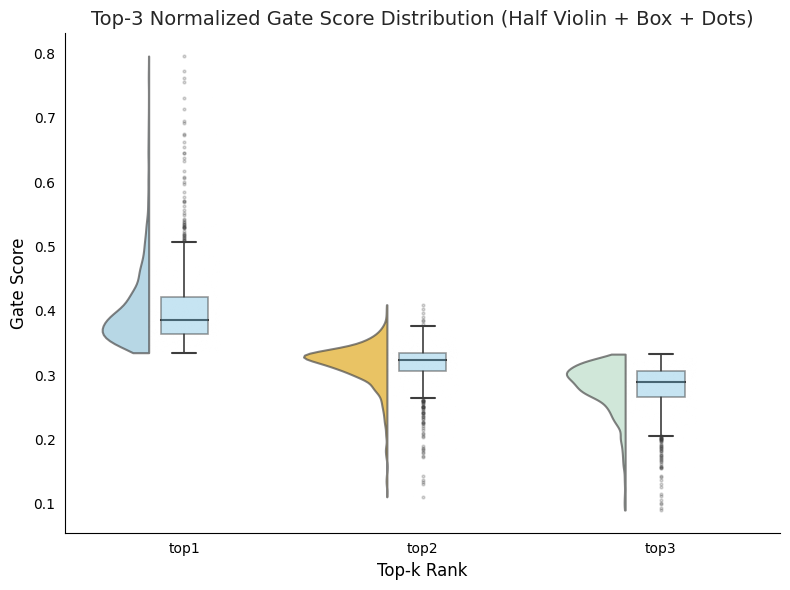

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# 假设 topk_vals 是 shape [N, 3] 的 numpy 数组
df_topk = pd.DataFrame(topk_vals, columns=['top1', 'top2', 'top3'])

# 采样每列3000个点，减少点数和PDF体积
sample_n = 1000
df_sampled = pd.concat([
    df_topk[col].sample(n=sample_n, random_state=42).reset_index(drop=True)
    for col in df_topk.columns
], axis=1)
df_long = df_sampled.melt(var_name="Top-k Rank", value_name="Gate Score")

violin_palette = ["#8ecae6", "#ffb703", "#b7e4c7"]
box_palette = ["#219ebc", "#fb8500", "#52b788"]  # 比小提琴深一点

plt.figure(figsize=(8,6))
ax = pt.half_violinplot(
    x="Top-k Rank", y="Gate Score", data=df_long, palette=violin_palette,
    bw=.2, cut=0, scale="area", width=.7, inner=None, orient="v",
    offset=0.15, alpha=0.7, ax=None
)
# 叠加箱型图（左半边，facecolor透明，width小一点）
sns.boxplot(
    x="Top-k Rank", y="Gate Score", data=df_long, width=0.2, showcaps=True,
    boxprops={'facecolor':'#8ecae6', 'alpha':0.5, 'zorder':10, 'linewidth':1.2},
    medianprops={'color':'black', 'linewidth':1.5},
    whiskerprops={'linewidth':1.2},
    showfliers=True, flierprops={'marker': 'o', 'markersize': 2, 'alpha': 0.2, 'color': 'gray'},
    ax=ax
)
# 叠加散点（全宽，点小透明度低）
sns.stripplot(
    x="Top-k Rank", y="Gate Score", data=df_long, size=0.3, color="k",
    alpha=0.03, jitter=0.15, ax=ax
)

ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

# 5. 坐标轴/刻度/标签全部黑色
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# 6. 英文标题和标签
plt.title("Top-3 Normalized Gate Score Distribution (Half Violin + Box + Dots)", fontsize=14)
plt.ylabel("Gate Score", fontsize=12)
plt.xlabel("Top-k Rank", fontsize=12)
plt.tight_layout()
plt.savefig("/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/gate_score_halfviolinright_box_scatter_rasterized.pdf", format='pdf', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

In [9]:
for i, scores in enumerate(expert_gate_scores):
    print(f"Expert_{i}: 非零分数数量={len(scores)}, 其中0分数量={(np.array(scores)==0).sum()}")
all_scores = gate_scores.flatten()
print("所有分数的描述性统计：")
print(pd.Series(all_scores).describe())
print("非零分数比例：", (all_scores != 0).sum() / all_scores.size)
assigned_scores = np.concatenate(expert_gate_scores)
print("被分配到的分数的描述性统计：")
print(pd.Series(assigned_scores).describe())
print("非零分数比例：", (assigned_scores != 0).sum() / assigned_scores.size)
# 假设 gate_scores: (num_layers, num_seqs, seq_len, num_experts)
# topk_idx: (num_layers, num_seqs, seq_len, topk)


print("topk归一化后分数的描述性统计：")
print(pd.DataFrame(topk_vals).describe())

Expert_0: 非零分数数量=155427, 其中0分数量=0
Expert_1: 非零分数数量=143621, 其中0分数量=0
Expert_2: 非零分数数量=76569, 其中0分数量=0
Expert_3: 非零分数数量=140242, 其中0分数量=0
Expert_4: 非零分数数量=278742, 其中0分数量=0
Expert_5: 非零分数数量=105259, 其中0分数量=0
Expert_6: 非零分数数量=92625, 其中0分数量=0
Expert_7: 非零分数数量=117328, 其中0分数量=0
Expert_8: 非零分数数量=79853, 其中0分数量=0
Expert_9: 非零分数数量=134443, 其中0分数量=0
Expert_10: 非零分数数量=80998, 其中0分数量=0
Expert_11: 非零分数数量=142911, 其中0分数量=0
Expert_12: 非零分数数量=138172, 其中0分数量=0
Expert_13: 非零分数数量=135457, 其中0分数量=0
Expert_14: 非零分数数量=125993, 其中0分数量=0
Expert_15: 非零分数数量=125233, 其中0分数量=0
Expert_16: 非零分数数量=109300, 其中0分数量=0
Expert_17: 非零分数数量=100920, 其中0分数量=0
Expert_18: 非零分数数量=192644, 其中0分数量=0
Expert_19: 非零分数数量=113523, 其中0分数量=0
Expert_20: 非零分数数量=131351, 其中0分数量=0
Expert_21: 非零分数数量=123406, 其中0分数量=0
Expert_22: 非零分数数量=174520, 其中0分数量=0
Expert_23: 非零分数数量=158406, 其中0分数量=0
Expert_24: 非零分数数量=127914, 其中0分数量=0
Expert_25: 非零分数数量=106291, 其中0分数量=0
Expert_26: 非零分数数量=193389, 其中0分数量=0
Expert_27: 非零分数数量=129606, 其中0分数量=0
Expert_28: 非零分数数量=115289, 其中0分数量=0

## 统计单条序列的各个专家使用情况

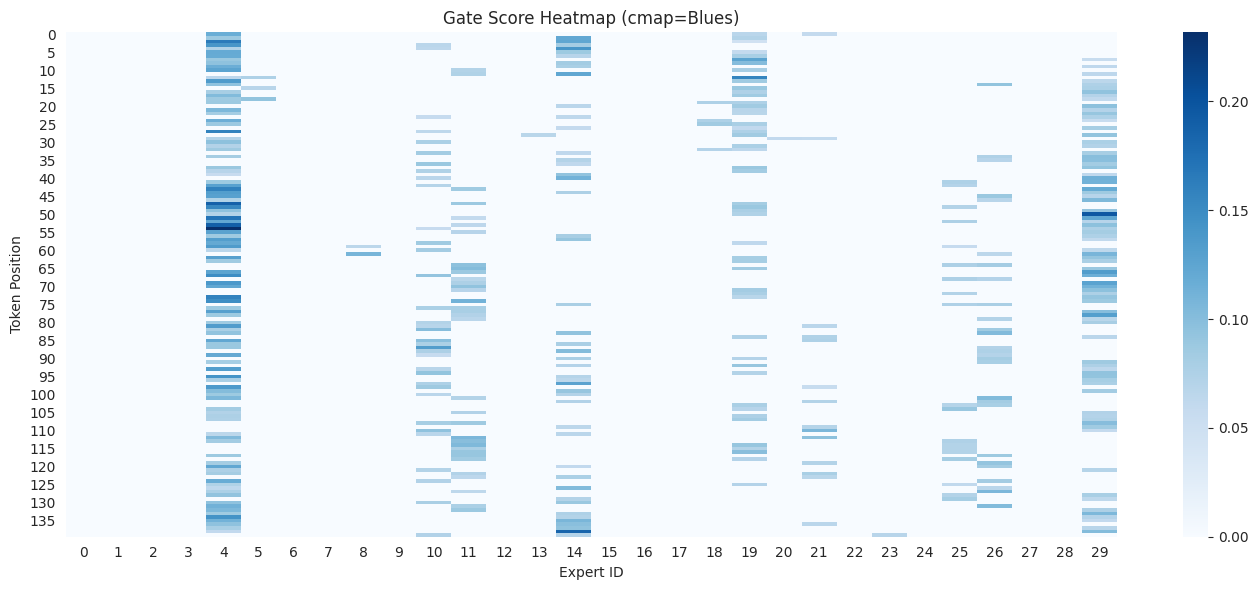

In [10]:
# 统计第一条序列全部140个token在硬路由下各专家的使用情况（0/1矩阵），并画热力图
# 统计第一条序列前140个token在硬路由下各专家的门控分数（只有3个专家非零，其余为0），并画热力图
seq_idx = 0
valid_token_len = 140
num_experts = gate_scores.shape[-1]
num_layers = gate_scores.shape[0]
topk = topk_idx.shape[-1]

gate_score_matrix = np.zeros((valid_token_len, num_experts))
for t in range(valid_token_len):
    for layer in range(1):
        for k in range(topk):
            eid = topk_idx[layer, seq_idx, t, k]
            score = gate_scores[layer, seq_idx, t, eid]
            gate_score_matrix[t, eid] += score  # 累加所有层的分数

np.save(os.path.join(data_save_dir, "first_seq_gate_score_matrix.npy"), gate_score_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

cmap='Blues'
plt.figure(figsize=(14, 6))
sns.heatmap(gate_score_matrix, cmap=cmap, cbar=True)
plt.xlabel("Expert ID")
plt.ylabel("Token Position")
plt.title(f"Gate Score Heatmap (cmap={cmap})")
plt.tight_layout()

plt.show()
plt.close()

/tmp/ipykernel_2795588/622119256.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


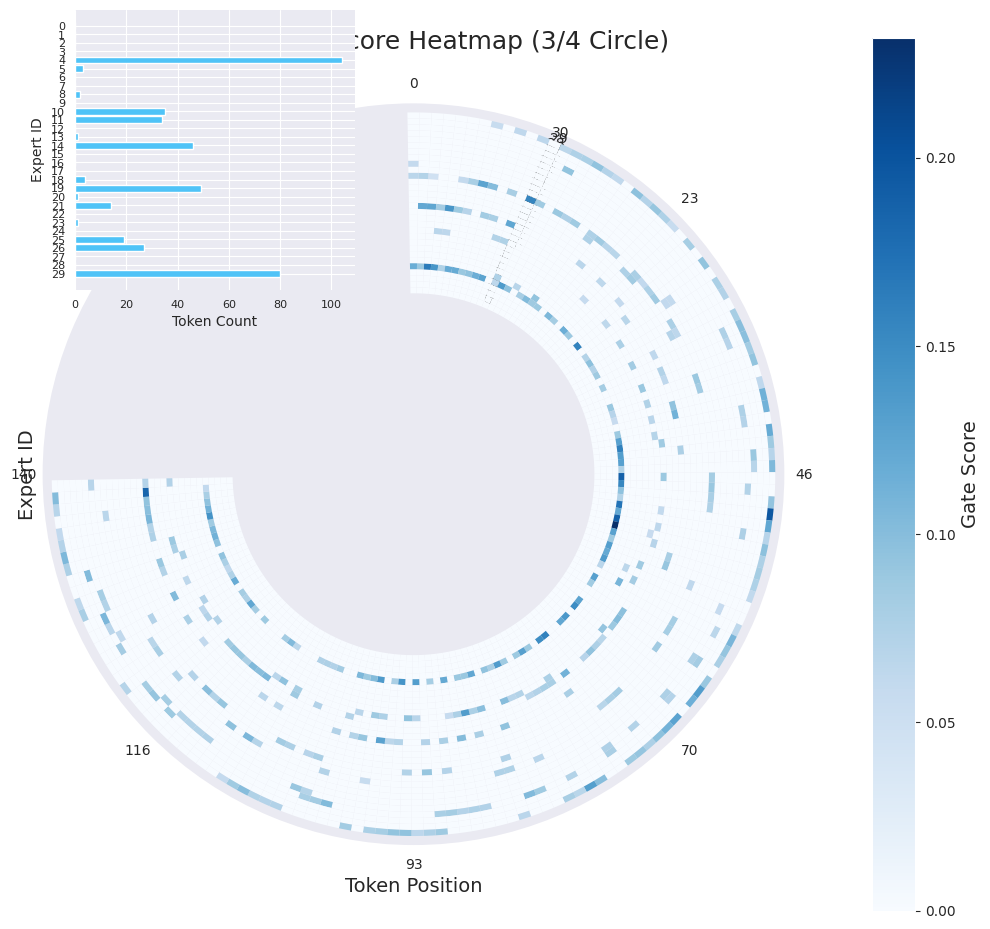

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 加载数据
gate_score_matrix = np.load(os.path.join(data_save_dir, "first_seq_gate_score_matrix.npy"))
num_tokens, num_experts = gate_score_matrix.shape
token_count_per_expert = (gate_score_matrix > 0).sum(axis=0)

# 环形热力图参数
theta_max = 3 * np.pi / 2  # 四分之三圆
theta = np.linspace(0, theta_max, num_tokens + 1)
r = np.linspace(1, 2, num_experts + 1)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

# 画四分之三圆的热力图
norm_matrix = (gate_score_matrix - gate_score_matrix.min()) / (gate_score_matrix.max() - gate_score_matrix.min() + 1e-8)
for i in range(num_tokens):
    for j in range(num_experts):
        val = norm_matrix[i, j]
        ax.bar(
            x=theta[i], height=r[j+1] - r[j], width=theta[1] - theta[0],
            bottom=r[j], color=plt.cm.Blues(val), edgecolor='none'
        )

# 美化极坐标
ax.set_xticks(np.linspace(0, theta_max, 7))
ax.set_xticklabels([f"{int(i)}" for i in np.linspace(0, num_tokens, 7)])
ax.set_yticks(r)
ax.set_yticklabels([str(i) for i in range(num_experts + 1)])
ax.set_ylabel("Expert ID", fontsize=14)
ax.set_xlabel("Token Position", fontsize=14)
ax.set_title("Circular Gate Score Heatmap (3/4 Circle)", fontsize=18, pad=20)
ax.grid(False)
ax.spines['polar'].set_visible(False)

# colorbar
import matplotlib as mpl
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=gate_score_matrix.min(), vmax=gate_score_matrix.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1, orientation='vertical', fraction=0.05)
cbar.set_label('Gate Score', fontsize=14)

# 在左上角加一个小的直角坐标系画柱状图
# [left, bottom, width, height]，数值0~1，左上角如[0.05, 0.65, 0.25, 0.25]
ax_bar = fig.add_axes([0.08, 0.68, 0.28, 0.28])
ax_bar.barh(np.arange(num_experts), token_count_per_expert, color="#4FC3F7")
ax_bar.set_yticks(np.arange(num_experts))
ax_bar.set_yticklabels([str(i) for i in range(num_experts)], fontsize=8)
ax_bar.set_xlabel("Token Count", fontsize=10)
ax_bar.set_ylabel("Expert ID", fontsize=10)
ax_bar.invert_yaxis()
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(axis='x', labelsize=8)
ax_bar.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, "first_seq_gate_score_circular_heatmap_with_bar_in_corner.pdf"), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# 专家专用性和偏好性分析（token类型未知，先统计专家分配的token分布）分析不同类别token更倾向于被哪些专家处理

In [12]:
import numpy as np

aa2idx = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}

def read_fasta(filepath):
    seqs = []
    with open(filepath) as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            seqs.append(seq)
    return seqs

# 读取正负样本
pos_seqs = read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/positive_test.fasta")
neg_seqs = read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/negative_test.fasta")

all_seqs = pos_seqs + neg_seqs  # 正样本在前，负样本在后
max_len = 300  # 和ESM嵌入保持一致
seqs_idx = np.full((len(all_seqs), max_len), -1, dtype=int)  # -1表示padding

for i, seq in enumerate(all_seqs):
    seq = seq[:max_len]  # 截断
    for j, aa in enumerate(seq):
        seqs_idx[i, j] = aa2idx.get(aa, -1)
    # 小于max_len的自动padding为-1

np.save("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/test_token_types.npy", seqs_idx)
print("test_token_types.npy saved! shape:", seqs_idx.shape)

test_token_types.npy saved! shape: (1149, 300)


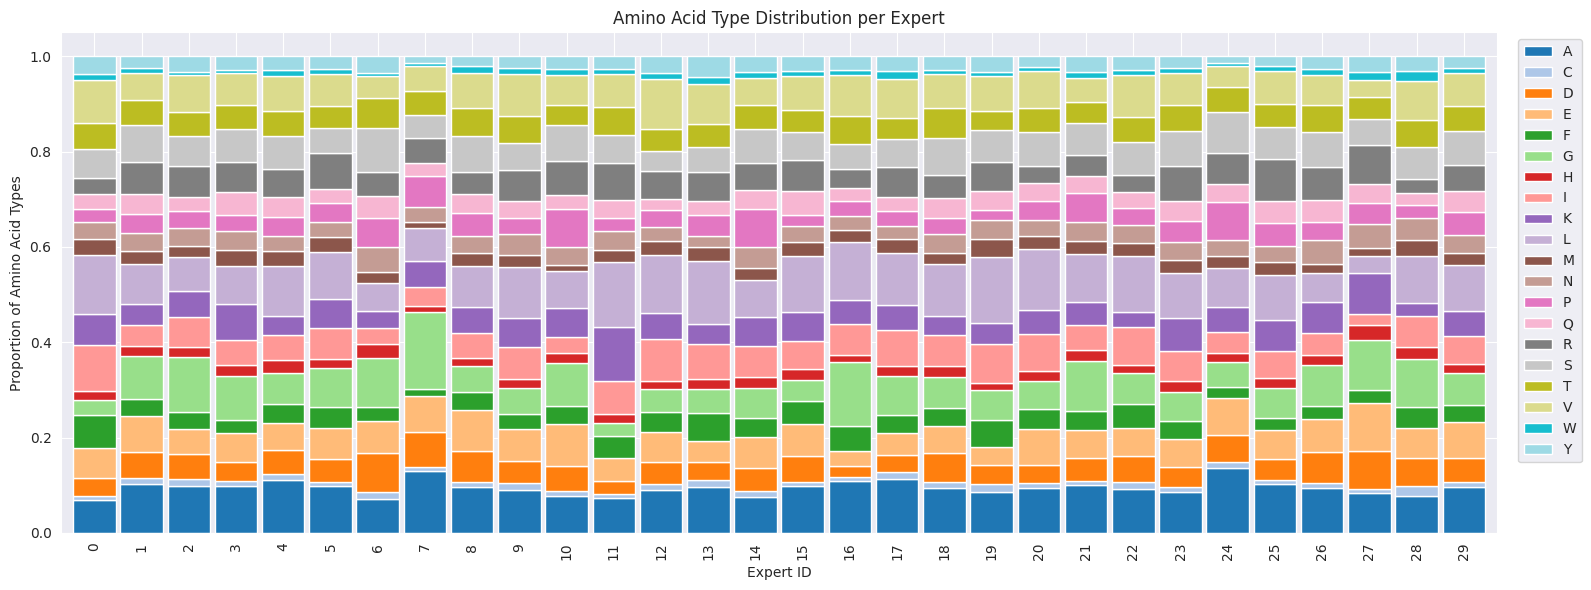

Expert 0: most preferred AA = L, count = 8772
Expert 1: most preferred AA = A, count = 9045
Expert 2: most preferred AA = G, count = 6197
Expert 3: most preferred AA = A, count = 7682
Expert 4: most preferred AA = A, count = 16872
Expert 5: most preferred AA = L, count = 7537
Expert 6: most preferred AA = G, count = 5105
Expert 7: most preferred AA = G, count = 7142
Expert 8: most preferred AA = A, count = 5007
Expert 9: most preferred AA = L, count = 7342
Expert 10: most preferred AA = G, count = 6452
Expert 11: most preferred AA = L, count = 10782
Expert 12: most preferred AA = L, count = 11611
Expert 13: most preferred AA = L, count = 10000
Expert 14: most preferred AA = P, count = 7937
Expert 15: most preferred AA = L, count = 9896
Expert 16: most preferred AA = G, count = 5540
Expert 17: most preferred AA = A, count = 10489
Expert 18: most preferred AA = L, count = 10990
Expert 19: most preferred AA = L, count = 13213
Expert 20: most preferred AA = L, count = 9182
Expert 21: most 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 加载数据
token_types = np.load("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/test_token_types.npy")  # (1149, 300)
topk_idx = np.load("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/topk_idx.npy")  # (4, 1149, 300, 3)

num_layers = topk_idx.shape[0]
num_seqs, seq_len = token_types.shape
num_experts = topk_idx.max() + 1
num_aa = 20  # 氨基酸种类数

# 统计每个专家分配到的氨基酸类型数量
expert_aa_count = np.zeros((num_experts, num_aa), dtype=int)

for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            for k in range(topk_idx.shape[-1]):
                eid = topk_idx[layer, i, t, k]
                aa = token_types[i, t]
                if 0 <= aa < num_aa:
                    expert_aa_count[eid, aa] += 1

# 可视化：每个专家的氨基酸分布（堆叠柱状图）
aa_list = list("ACDEFGHIKLMNPQRSTVWY")
df = pd.DataFrame(expert_aa_count, columns=aa_list)
df.index.name = "Expert"
df_norm = df.div(df.sum(axis=1), axis=0)  # 行归一化

plt.figure(figsize=(16, 6))
df_norm.plot(kind="bar", stacked=True, colormap="tab20", width=0.9, ax=plt.gca())
plt.xlabel("Expert ID")
plt.ylabel("Proportion of Amino Acid Types")
plt.title("Amino Acid Type Distribution per Expert")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/expert_aa_distribution_stackedbar.pdf",format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# 也可以输出每个专家最偏好的氨基酸类型
for eid in range(num_experts):
    top_aa = aa_list[np.argmax(expert_aa_count[eid])]
    print(f"Expert {eid}: most preferred AA = {top_aa}, count = {expert_aa_count[eid].max()}")

### 氨基酸理化性质偏好分析

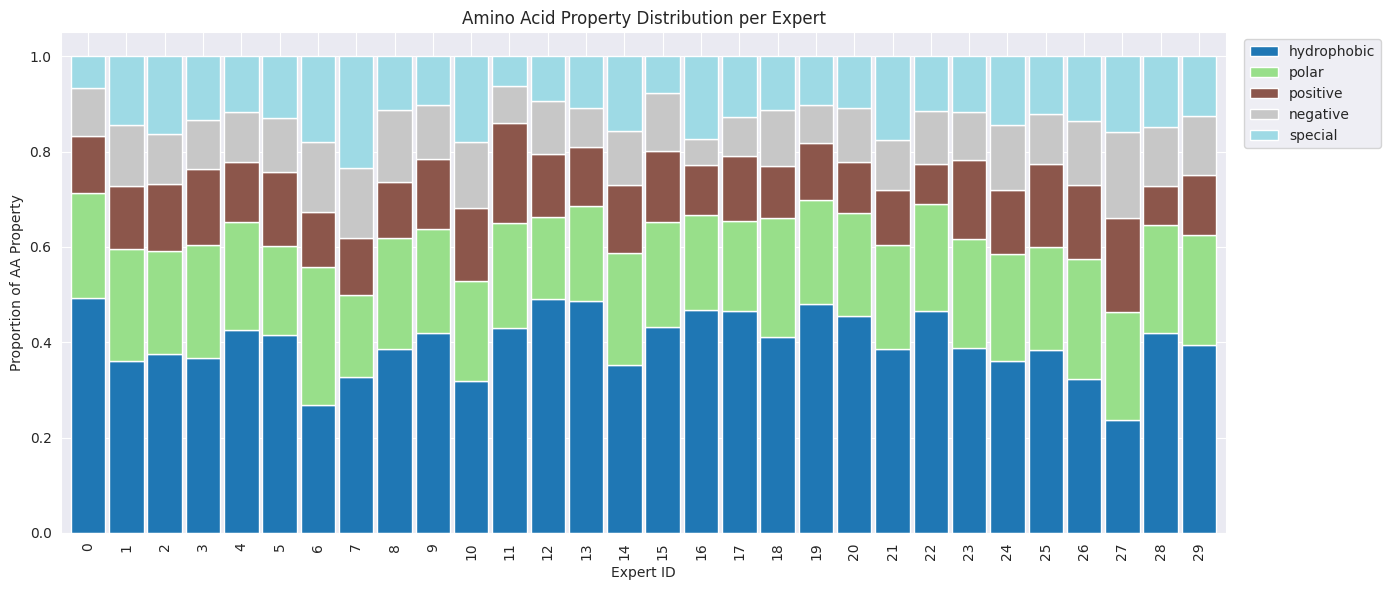

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 氨基酸理化分类
hydrophobic = set("AILMFWV")
polar = set("NQSTY")
positive = set("KRH")
negative = set("DE")
special = set("CGP")
aa2group = {}
for aa in hydrophobic: aa2group[aa] = "hydrophobic"
for aa in polar: aa2group[aa] = "polar"
for aa in positive: aa2group[aa] = "positive"
for aa in negative: aa2group[aa] = "negative"
for aa in special: aa2group[aa] = "special"
aa_list = list("ACDEFGHIKLMNPQRSTVWY")
aa_idx2group = [aa2group.get(aa, "other") for aa in aa_list]
group_names = ["hydrophobic", "polar", "positive", "negative", "special"]

# 加载数据
token_types = np.load("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/test_token_types.npy")
topk_idx = np.load("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/topk_idx.npy")
num_layers = topk_idx.shape[0]
num_seqs, seq_len = token_types.shape
num_experts = topk_idx.max() + 1

# 统计每个专家分配到的理化类别数量
expert_group_count = np.zeros((num_experts, len(group_names)), dtype=int)
for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            for k in range(topk_idx.shape[-1]):
                eid = topk_idx[layer, i, t, k]
                aa = token_types[i, t]
                if 0 <= aa < 20:
                    group = aa_idx2group[aa]
                    if group in group_names:
                        expert_group_count[eid, group_names.index(group)] += 1

df_group = pd.DataFrame(expert_group_count, columns=group_names)
df_group_norm = df_group.div(df_group.sum(axis=1), axis=0)
plt.figure(figsize=(14, 6))
df_group_norm.plot(kind="bar", stacked=True, colormap="tab20", width=0.9, ax=plt.gca())
plt.xlabel("Expert ID")
plt.ylabel("Proportion of AA Property")
plt.title("Amino Acid Property Distribution per Expert")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/expert_aa_property_distribution.pdf",format='pdf', bbox_inches='tight')
plt.show()
plt.close()

### 正负样本偏好分析

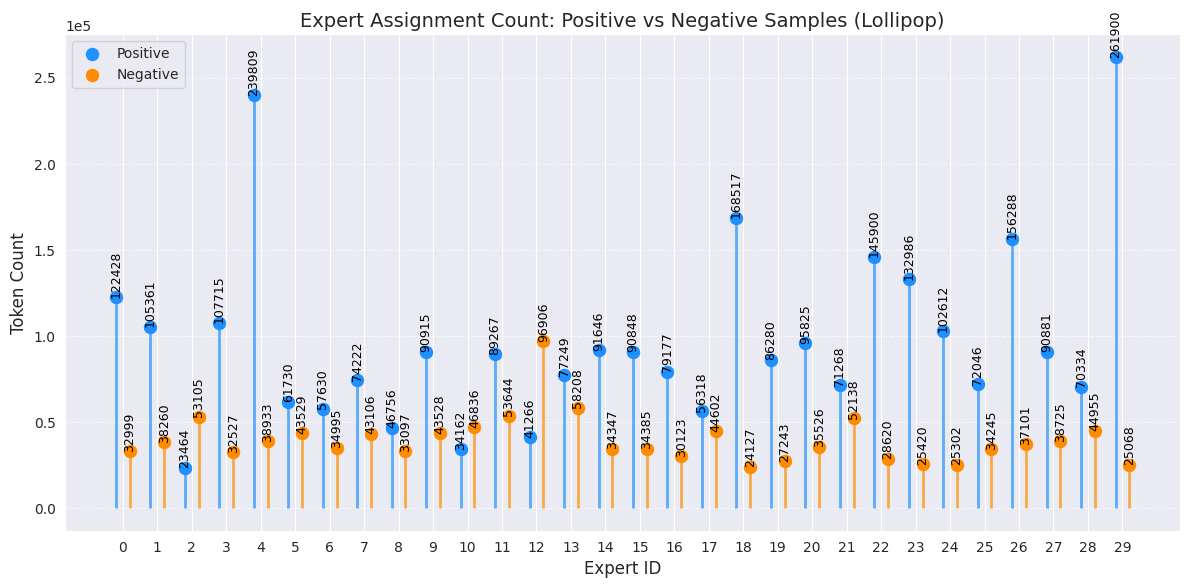

In [15]:
# 假设正样本在前，负样本在后
num_pos = len(read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/positive_test.fasta"))
num_neg = len(read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/negative_test.fasta"))
# 但fasta不能直接np.load，需用前面read_fasta函数
def read_fasta(filepath):
    seqs = []
    with open(filepath) as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            seqs.append(seq)
    return seqs
num_pos = len(read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/positive_test.fasta"))
num_neg = len(read_fasta("/exp_data/sjx/star/first_data/shisuandanbai/negative_test.fasta"))

# 分别统计正负样本专家分配
expert_token_counts_pos = np.zeros(num_experts, dtype=int)
expert_token_counts_neg = np.zeros(num_experts, dtype=int)
for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            for k in range(topk_idx.shape[-1]):
                eid = topk_idx[layer, i, t, k]
                if i < num_pos:
                    expert_token_counts_pos[eid] += 1
                else:
                    expert_token_counts_neg[eid] += 1

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 6))
x_pos = np.arange(num_experts)

# 正样本的棒棒糖图 (蓝色)
plt.vlines(x=x_pos - 0.2, ymin=0, ymax=expert_token_counts_pos, color='dodgerblue', alpha=0.7, linewidth=2)
plt.scatter(x=x_pos - 0.2, y=expert_token_counts_pos, color='dodgerblue', s=75, alpha=1, label="Positive")

# 负样本的棒棒糖图 (橙色)
plt.vlines(x=x_pos + 0.2, ymin=0, ymax=expert_token_counts_neg, color='darkorange', alpha=0.7, linewidth=2)
plt.scatter(x=x_pos + 0.2, y=expert_token_counts_neg, color='darkorange', s=75, alpha=1, label="Negative")

# 在棒棒糖头部标注具体数值（黑色字体）
for i in range(num_experts):
    plt.text(x_pos[i] - 0.2, expert_token_counts_pos[i], f"{expert_token_counts_pos[i]}", 
             ha='center', va='bottom', fontsize=9, color='black', rotation=90)
    plt.text(x_pos[i] + 0.2, expert_token_counts_neg[i], f"{expert_token_counts_neg[i]}", 
             ha='center', va='bottom', fontsize=9, color='black', rotation=90)

plt.xlabel("Expert ID", fontsize=12)
plt.ylabel("Token Count", fontsize=12)
plt.title("Expert Assignment Count: Positive vs Negative Samples (Lollipop)", fontsize=14)
plt.xticks(x_pos)

# 格式化Y轴，使其更易读
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(10)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/expert_pos_neg_distribution_lollipop.pdf", format='pdf')
plt.show()
plt.close()

### 专家分配token的门控分数分布

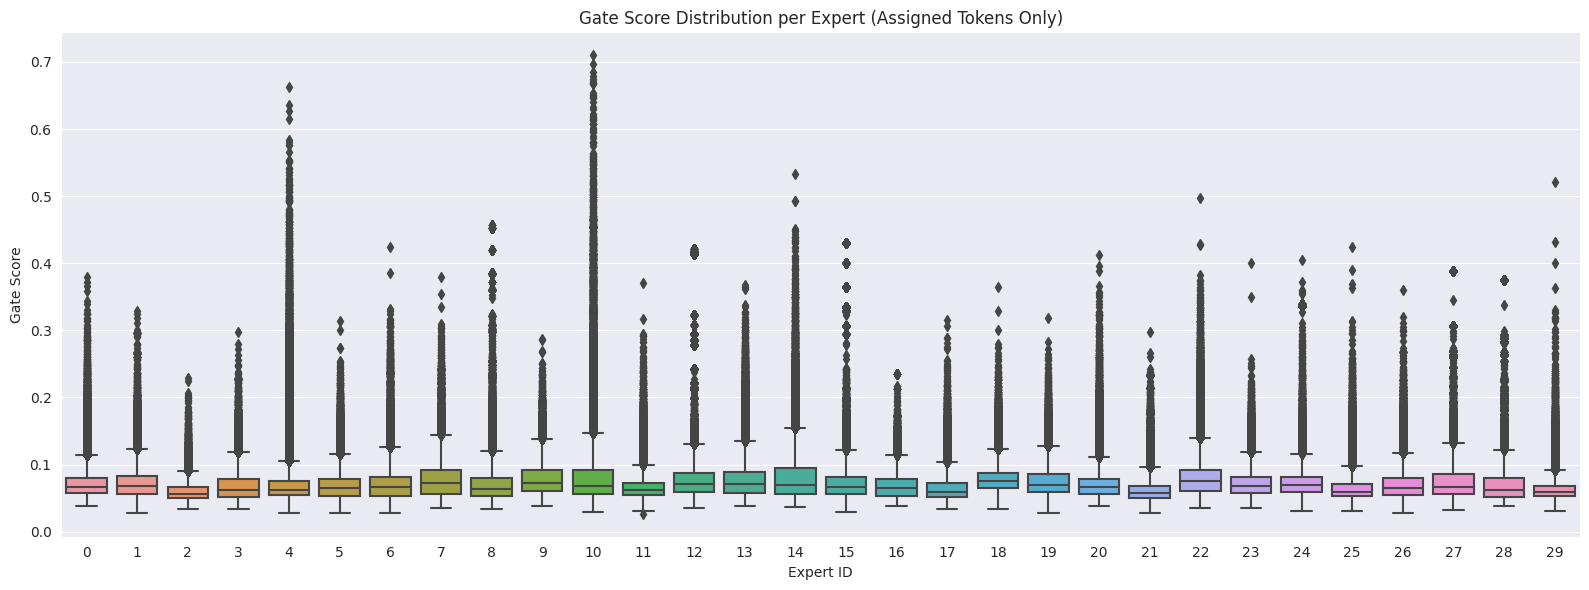

In [16]:
gate_scores = np.load("/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/gate_scores.npy")
# gate_scores: (4, 1149, 300, 30)
expert_gate_scores = [[] for _ in range(num_experts)]
for layer in range(num_layers):
    for i in range(num_seqs):
        for t in range(seq_len):
            for k in range(topk_idx.shape[-1]):
                eid = topk_idx[layer, i, t, k]
                score = gate_scores[layer, i, t, eid]
                expert_gate_scores[eid].append(score)
import seaborn as sns
plt.figure(figsize=(16,6))
sns.boxplot(data=[expert_gate_scores[eid] for eid in range(num_experts)])
plt.xlabel("Expert ID")
plt.ylabel("Gate Score")
plt.title("Gate Score Distribution per Expert (Assigned Tokens Only)")
plt.tight_layout()
plt.show()
plt.close()

### 专家分配token的多样性（香农熵）

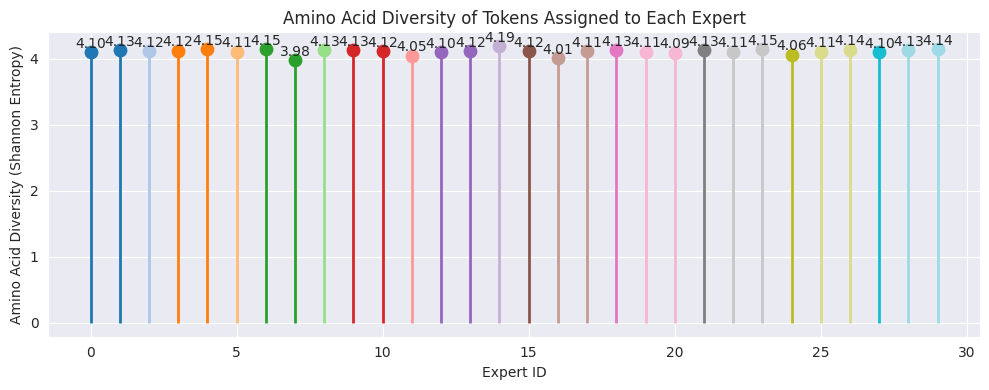

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 假设 num_experts, token_types, topk_idx 已经定义并赋值
expert_aa_entropy = []
for eid in range(num_experts):
    aa_counts = np.zeros(20, dtype=int)
    for aa in range(20):
        aa_counts[aa] = np.sum((token_types == aa) & (np.any(topk_idx == eid, axis=(0,3))))
    p = aa_counts / (aa_counts.sum() + 1e-12)
    expert_aa_entropy.append(entropy(p, base=2))

plt.figure(figsize=(10,4))
x = np.arange(num_experts)
y = expert_aa_entropy

colors = plt.cm.tab20(np.linspace(0, 1, num_experts))

for i in range(num_experts):
    plt.vlines(x[i], 0, y[i], color=colors[i], linewidth=2)
    plt.scatter(x[i], y[i], color=colors[i], s=80, zorder=3)
    # 在棒棒糖头部上方打印具体数值，保留两位小数
    plt.text(x[i], y[i]+0.02, f"{y[i]:.2f}", ha='center', va='bottom', fontsize=10)

plt.xlabel("Expert ID")
plt.ylabel("Amino Acid Diversity (Shannon Entropy)")
plt.title("Amino Acid Diversity of Tokens Assigned to Each Expert")
plt.tight_layout()
plt.savefig("/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/expert_aa_entropy.pdf",format='pdf')
plt.show()
plt.close()

### 专家对序列结构区域的偏好

### 专家分配的token在序列中的位置分布

# 负载均衡度量


In [18]:
# 统计每个专家被分配到的token数量
all_expert_ids = topk_idx.reshape(-1)
num_experts = gate_scores.shape[-1]
expert_token_counts = np.zeros(num_experts, dtype=int)
for eid in range(num_experts):
    expert_token_counts[eid] = np.sum(all_expert_ids == eid)
probs = expert_token_counts / expert_token_counts.sum()
entropy = -np.sum(probs * np.log(probs + 1e-12))
max_min_ratio = expert_token_counts.max() / (expert_token_counts.min() + 1e-12)
std = expert_token_counts.std()
num_collapsed = np.sum(expert_token_counts == 0)

print(f"专家分配比例: {probs}")
print(f"负载均衡熵: {entropy:.4f} (最大值: {np.log(len(expert_token_counts)):.4f})")
print(f"最大/最小分配比: {max_min_ratio:.2f}")
print(f"塌陷专家数量（分配为0）: {num_collapsed}")

专家分配比例: [0.03757543 0.03472126 0.01851102 0.03390436 0.06738758 0.02544701
 0.02239266 0.02836476 0.01930495 0.03250242 0.01958176 0.03454961
 0.03340393 0.03274756 0.03045958 0.03027584 0.02642394 0.02439803
 0.04657287 0.02744488 0.03175491 0.02983416 0.04219128 0.03829562
 0.03092399 0.0256965  0.04675297 0.03133304 0.02787182 0.06937627]
负载均衡熵: 3.3476 (最大值: 3.4012)
最大/最小分配比: 3.75
塌陷专家数量（分配为0）: 0


## 专家输出相关性   内存太大，没有成功

### 专家输出t_sne降维和PCA降维，看是否分离说明提取得特征给你不同

重塑后数据形状: (344700, 3, 1152)
专家平均输出形状: (3, 1152)
相关性矩阵形状: (3, 3)
相关性矩阵:
[[1.         0.995572   0.98890448]
 [0.995572   1.         0.99799688]
 [0.98890448 0.99799688 1.        ]]


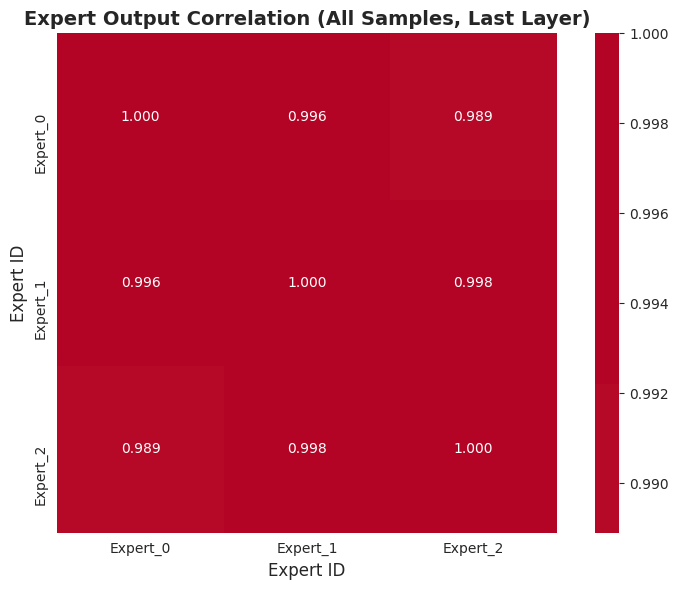

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

expert_outs_path = '/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/expert_outs_lastlayer.npy'
save_dir = '/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/'
os.makedirs(save_dir, exist_ok=True)

# 1. 内存映射方式加载
data = np.load(expert_outs_path, mmap_mode='r')  # (1149, 300, 3, 1152)

reshaped_data = data.reshape(-1, data.shape[2], data.shape[3])  # (344700, 3, 1152)
print("重塑后数据形状:", reshaped_data.shape)

expert_means = np.mean(reshaped_data, axis=0)  # (3, 1152)
print("专家平均输出形状:", expert_means.shape)

# Cell 5: 计算专家间相关性矩阵
corr_matrix = np.corrcoef(expert_means)
print("相关性矩阵形状:", corr_matrix.shape)
print("相关性矩阵:")
print(corr_matrix)

# Cell 6: 可视化专家间相关性
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.3f', square=True,
            xticklabels=[f'Expert_{i}' for i in range(corr_matrix.shape[0])],
            yticklabels=[f'Expert_{i}' for i in range(corr_matrix.shape[0])])
plt.title('Expert Output Correlation (All Samples, Last Layer)', fontsize=14, fontweight='bold')
plt.xlabel('Expert ID', fontsize=12)
plt.ylabel('Expert ID', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'expert_output_correlation_all_samples.svg'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 正负样本氨基酸相关性分析

In [20]:
from collections import Counter
import numpy as np

def read_fasta(filepath):
    seqs = []
    with open(filepath, 'r') as f:
        seq = ''
        for line in f:
            if line.startswith('>'):
                if seq:
                    seqs.append(seq)
                    seq = ''
            else:
                seq += line.strip()
        if seq:
            seqs.append(seq)
    return seqs

# 合并正负样本
pos_train = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/positive_train.fasta')
pos_test = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/positive_test.fasta')
neg_train = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/negative_train.fasta')
neg_test = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/negative_test.fasta')

pos_seqs = pos_train + pos_test
neg_seqs = neg_train + neg_test

# 统计全局频率
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
def get_freq(seqs):
    total = Counter()
    total_len = 0
    for seq in seqs:
        total.update(seq)
        total_len += len(seq)
    freq = np.array([total[aa] for aa in amino_acids], dtype=float) / total_len
    return freq

pos_freq = get_freq(pos_seqs)
neg_freq = get_freq(neg_seqs)
print(pos_freq)
print(neg_freq)

[0.09535451 0.01341806 0.04773553 0.05741217 0.03845428 0.07216244
 0.02146299 0.05863816 0.05545589 0.09660705 0.02785556 0.03783759
 0.04265009 0.04116592 0.05584242 0.07475458 0.05485543 0.0697075
 0.01103394 0.0275841 ]
[0.09661102 0.00910967 0.05337466 0.07383291 0.03881578 0.0762278
 0.01955992 0.06326025 0.05421179 0.1046032  0.02322037 0.03310398
 0.04491851 0.03001412 0.06381307 0.05218413 0.04633412 0.07563549
 0.01176912 0.02939812]


In [ ]:
import numpy as np
from collections import Counter

# 更高效的方法：直接计算20种氨基酸之间的相关性
def get_aa_correlation_matrix(seqs, amino_acids="ACDEFGHIKLMNPQRSTVWY"):
    aa_list = list(amino_acids)
    aa2idx = {aa: i for i, aa in enumerate(aa_list)}
    aa_freq_matrix = np.zeros((len(aa_list), len(seqs)))
    for i, seq in enumerate(seqs):
        # 如果seq是字符串，先转成list；如果是int数组，先过滤-1
        if isinstance(seq[0], str):
            valid_aa = [aa for aa in seq if aa in aa2idx]
        else:
            # int编码，-1为padding
            valid_aa = [aa for aa in seq if aa != -1]
            # 需要把int转回字母
            valid_aa = [aa_list[aa] for aa in valid_aa if 0 <= aa < 20]
        total_len = len(valid_aa)
        c = Counter(valid_aa)
        for j, aa in enumerate(aa_list):
            aa_freq_matrix[j, i] = c[aa] / total_len if total_len > 0 else 0
    corr_matrix = np.corrcoef(aa_freq_matrix)
    return corr_matrix

print("计算正样本氨基酸相关性...")
pos_corr = get_aa_correlation_matrix(pos_seqs)
print("计算负样本氨基酸相关性...")
neg_corr = get_aa_correlation_matrix(neg_seqs)

print(f"正样本序列数: {len(pos_seqs)}")
print(f"负样本序列数: {len(neg_seqs)}")
print(f"相关性矩阵形状: {pos_corr.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.patches import Rectangle

# 假设你已经有 pos_corr, neg_corr, amino_acids
pos_corr_df = pd.DataFrame(pos_corr, index=amino_acids, columns=amino_acids)
neg_corr_df = pd.DataFrame(neg_corr, index=amino_acids, columns=amino_acids)

def plot_corr_beauty(corr_df, title, save_path, highlight_boxes=None):
    n = len(corr_df)
    plt.figure(figsize=(10, 9))
    ax = plt.gca()
    # 右上角（含主对角线）：画圆圈，主对角线只显示字母
    for i in range(n):
        for j in range(i, n):
            val = corr_df.iloc[i, j]
            if i == j:
                # 主对角线：只显示字母
                ax.text(j, i, corr_df.columns[i], ha='center', va='center', fontsize=15, fontweight='bold', color='r')
            else:
                color = plt.cm.coolwarm((val+0.4)/0.8)
                size = abs(val)*800 if abs(val)>0.01 else 0
                ax.scatter(j, i, s=size, color=color, alpha=0.8, edgecolor='k', linewidth=0.5)
    # 左下角：显示数值
    for i in range(1, n):
        for j in range(i):
            val = corr_df.iloc[i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10, color='w' if abs(val)>0.2 else 'gray')
    # 高亮部分区域
    if highlight_boxes:
        for (i0, j0, w, h) in highlight_boxes:
            rect = Rectangle((j0-0.5, i0-0.5), w, h, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(rect)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr_df.columns, fontsize=13)
    ax.set_yticklabels(corr_df.index, fontsize=13)
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    plt.title(title, fontsize=16)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-0.4, vmax=0.4))
    cbar = plt.colorbar(sm, ax=ax, fraction=0.045, pad=0.03, orientation='horizontal')
    cbar.set_label('Correlation', fontsize=13)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

save_dir = '/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/'
os.makedirs(save_dir, exist_ok=True)
highlight_boxes = [(13, 14, 2, 2), (16, 18, 3, 3)]  # 可根据需要调整

plot_corr_beauty(pos_corr_df, 'Amino Acid Correlation (Positive, Beauty)', os.path.join(save_dir, 'positive_aa_correlation_beauty.svg'), highlight_boxes)
plot_corr_beauty(neg_corr_df, 'Amino Acid Correlation (Negative, Beauty)', os.path.join(save_dir, 'negative_aa_correlation_beauty.svg'), highlight_boxes)

In [ ]:
# Cell 1: 导入依赖
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
# Cell 2: 加载数据
attn_weights_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/attn_weights.npy"
gate_scores_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/gate_scores.npy"
topk_idx_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/topk_idx.npy"
token_types_path = "/exp_data/sjx/star/main_transformer_moe_weight/experiment_data/test_token_types.npy"

attn_weights = np.load(attn_weights_path)  # (4, 1149, 300, 300)
gate_scores = np.load(gate_scores_path)    # (4, 1149, 300, 30)
topk_idx = np.load(topk_idx_path)          # (4, 1149, 300, 3)
token_types = np.load(token_types_path)    # (1149, 300)

print("数据形状:")
print(f"attn_weights: {attn_weights.shape}")
print(f"gate_scores: {gate_scores.shape}")
print(f"topk_idx: {topk_idx.shape}")
print(f"token_types: {token_types.shape}")

# Cell 3: 选择要分析的序列和层
seq_idx = 0  # 第一条序列
layer_idx = 0  # 第一层
seq_len = 140  # 实际序列长度（去除padding）

# 获取该序列的数据
seq_attn = attn_weights[layer_idx, seq_idx, :seq_len, :seq_len]  # (seq_len, seq_len)
seq_gate = gate_scores[layer_idx, seq_idx, :seq_len]  # (seq_len, 30)
seq_experts = topk_idx[layer_idx, seq_idx, :seq_len]  # (seq_len, 3)
seq_tokens = token_types[seq_idx, :seq_len]  # (seq_len,)

print(f"分析序列 {seq_idx}，层 {layer_idx}，长度 {seq_len}")
# Cell 4: 准备桑基图数据 - Token到Expert的分配
def prepare_sankey_data(seq_attn, seq_gate, seq_experts, seq_tokens, top_k=3):
    """
    准备桑基图数据：Token -> Expert -> Attention Weight
    """
    # 节点定义
    token_nodes = [f"Token_{i}" for i in range(len(seq_tokens))]

    expert_nodes = [f"Expert_{eid}" for eid in range(30)]
    
    # 边数据
    source = []
    target = []
    value = []
    color = []
    
    # Token到Expert的连接
    for token_idx in range(len(seq_tokens)):
        if seq_tokens[token_idx] == -1:  # 跳过padding
            continue
            
        for k in range(top_k):
            expert_id = seq_experts[token_idx, k]
            gate_score = seq_gate[token_idx, expert_id]
            
            source.append(token_idx)
            target.append(len(token_nodes) + expert_id)
            value.append(gate_score)
            color.append(f"rgba(100, 149, 237, {gate_score})")
    
    # Expert到Attention的连接
    attention_in = seq_attn.sum(axis=0)  # 每个token被关注的程度
    
    for expert_id in range(30):
        # 找出该专家处理的token
        expert_tokens = []
        for token_idx in range(len(seq_tokens)):
            if expert_id in seq_experts[token_idx]:
                expert_tokens.append(token_idx)
        
        if expert_tokens:
            # 计算该专家处理的token的平均注意力
            avg_attention = np.mean([attention_in[t] for t in expert_tokens])
            
            source.append(len(token_nodes) + expert_id)
            target.append(len(token_nodes) + 30)  # 虚拟的"Attention"节点
            value.append(avg_attention)
            color.append(f"rgba(255, 99, 71, {avg_attention})")
    
    return token_nodes, expert_nodes, source, target, value, color

token_nodes, expert_nodes, source, target, value, color = prepare_sankey_data(
    seq_attn, seq_gate, seq_experts, seq_tokens
)
# Cell 5: 创建桑基图
def create_sankey_diagram(token_nodes, expert_nodes, source, target, value, color):
    """
    创建桑基图
    """
    # 所有节点
    all_nodes = token_nodes + expert_nodes + ["Attention"]
    node_colors = ["lightblue"] * len(token_nodes) + ["lightgreen"] * len(expert_nodes) + ["lightcoral"]
    
    # 创建桑基图
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = all_nodes,
            color = node_colors
        ),
        link = dict(
            source = source,
            target = target,
            value = value,
            color = color
        )
    )])
    
    fig.update_layout(
    title_text=f"Token-Expert-Attention Flow (Sequence {seq_idx}, Layer {layer_idx})",
    font_size=10,
    height=800,
)

    
    return fig

fig = create_sankey_diagram(token_nodes, expert_nodes, source, target, value, color)
fig.show()
# Cell 6: 保存桑基图
save_path = f"/exp_data/sjx/star/main_transformer_moe_weight/moe_analysis/sankey_seq{seq_idx}_layer{layer_idx}.html"
fig.write_html(save_path)
print(f"桑基图已保存到: {save_path}")

In [ ]:
# Cell 1: 导入依赖
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
# Cell 2: 读取 FASTA 格式的氨基酸序列
def read_fasta(filepath):
    seqs = []
    with open(filepath, 'r') as f:
        seq = ''
        for line in f:
            if line.startswith('>'):
                if seq:
                    seqs.append(seq)
                    seq = ''
            else:
                seq += line.strip()
        if seq:
            seqs.append(seq)
    return seqs

# 读取正负样本序列
pos_train = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/positive_train.fasta')
pos_test = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/positive_test.fasta')
neg_train = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/negative_train.fasta')
neg_test = read_fasta('/exp_data/sjx/star/first_data/shisuandanbai/negative_test.fasta')

pos_seqs = pos_train + pos_test
neg_seqs = neg_train + neg_test

print(f"正样本序列数: {len(pos_seqs)}")
print(f"负样本序列数: {len(neg_seqs)}")
print(f"第一条正样本序列: {pos_seqs[0][:50]}...")
# Cell 3: 设置氨基酸顺序
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
num_aa = len(amino_acids)
print("氨基酸列表:", amino_acids)
# Cell 4: 计算正样本氨基酸相关性矩阵
def get_aa_correlation_matrix(seqs):
    """
    计算20种氨基酸之间的相关性矩阵
    seqs: list of strings, 每条序列是氨基酸字符串
    """
    aa_freq_matrix = np.zeros((len(amino_acids), len(seqs)))
    
    for i, seq in enumerate(seqs):
        # 只统计真实氨基酸，不统计其他字符
        valid_aa = [aa for aa in seq if aa in amino_acids]
        total_len = len(valid_aa)
        if total_len == 0:
            print(f"Warning: sequence {i} has no valid amino acids!")
            continue
        c = Counter(valid_aa)
        for j, aa in enumerate(amino_acids):
            aa_freq_matrix[j, i] = c[aa] / total_len
    
    corr_matrix = np.corrcoef(aa_freq_matrix)
    return corr_matrix

print("计算正样本氨基酸相关性...")
pos_corr = get_aa_correlation_matrix(pos_seqs)
# Cell 5: 计算负样本氨基酸相关性矩阵
print("计算负样本氨基酸相关性...")
neg_corr = get_aa_correlation_matrix(neg_seqs)
# Cell 6: 检查相关性矩阵
print("正样本相关性矩阵最大值：", np.max(pos_corr))
print("正样本相关性矩阵最小值：", np.min(pos_corr))
print("负样本相关性矩阵最大值：", np.max(neg_corr))
print("负样本相关性矩阵最小值：", np.min(neg_corr))
# Cell 7: 转换为DataFrame
pos_corr_df = pd.DataFrame(pos_corr, index=amino_acids, columns=amino_acids)
neg_corr_df = pd.DataFrame(neg_corr, index=amino_acids, columns=amino_acids)
# Cell 8: 画图函数
def plot_corr_beauty(corr_df, title, save_path, highlight_boxes=None):
    n = len(corr_df)
    plt.figure(figsize=(10, 9))
    ax = plt.gca()
    # 右上角（含主对角线）：画圆圈，主对角线只显示字母
    for i in range(n):
        for j in range(i, n):
            val = corr_df.iloc[i, j]
            if i == j:
                # 主对角线：只显示字母
                ax.text(j, i, corr_df.columns[i], ha='center', va='center', fontsize=15, fontweight='bold', color='r')
            else:
                color = plt.cm.coolwarm((val+0.4)/0.8)
                size = abs(val)*800 if abs(val)>0.01 else 0
                ax.scatter(j, i, s=size, color=color, alpha=0.8, edgecolor='k', linewidth=0.5)
    # 左下角：显示数值
    for i in range(1, n):
        for j in range(i):
            val = corr_df.iloc[i, j]
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10, color='w' if abs(val)>0.2 else 'gray')
    # 高亮部分区域
    if highlight_boxes:
        for (i0, j0, w, h) in highlight_boxes:
            rect = Rectangle((j0-0.5, i0-0.5), w, h, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(rect)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr_df.columns, fontsize=13)
    ax.set_yticklabels(corr_df.index, fontsize=13)
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    plt.title(title, fontsize=16)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-0.4, vmax=0.4))
    cbar = plt.colorbar(sm, ax=ax, fraction=0.045, pad=0.03, orientation='horizontal')
    cbar.set_label('Correlation', fontsize=13)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

）